In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

input_sizes = [1, 2, 8, 16, 32, 64, 128, 256]

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
        
    for size in input_sizes:
        with open(os.path.join(path, str(size), 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
            
            report[function_name][size] = data['median']['point_estimate']
        

In [2]:
df = pd.DataFrame(report)
df

,cost_add,cost_sub
1,3.377358e+06,3.232999e+06
2,4.267805e+06,4.505465e+06
8,9.174882e+06,1.074067e+07
16,1.831843e+07,1.835564e+07
32,3.759202e+07,3.636992e+07
64,8.210660e+07,7.887210e+07
128,1.639732e+08,2.892580e+08
256,4.535765e+08,4.983142e+08


In [42]:
def estimate_params(df, name, transform = lambda x: x):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)

    b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)

    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output):
    a, b = estimate_params(df, fun_name)
    output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    plot(df, fun_name, a, b)

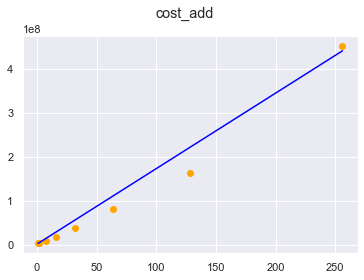

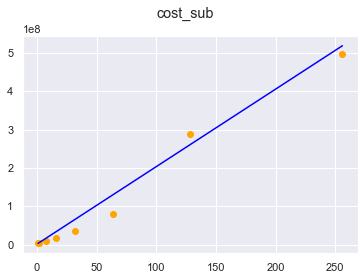

,a,b
cost_add,1719783.6917487958,1657574.5749178708
cost_sub,2021345.132454916,1211653.7246879414


In [43]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)

output